# Introduction
This notebook will define functions to generate a simple float dataset and labels for clustering.
It will then test AntClust on these sets.
The clustering performance is evaluated (scored) via the Adjusted Rand Index score method (the scikit-learn implementation is used).
Finally plots are made that show the clustering performance.
The idea is to apply Genetic Algorithm to the parameters of AntClust
    
    

# imports

In [1]:
# make AntClus dir known
import sys
sys.path.append("../AntClust")

# generally used
import random as rng
import time
from concurrent.futures import ProcessPoolExecutor

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from AntClust import AntClust
from distance_classes import similarity_1d
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from rules import labroche_rules
from sklearn.metrics import adjusted_rand_score, rand_score

# data generation methods

In [8]:
def uniform_cluster_data_random(
    num_clusters,
    cluster_width,
    values_per_cluster_min=0,
    values_per_cluster_max=100,
    rng_seed=1,
):
    """
    Makes a series of numbers that can be clustered together.
    Each cluster is getting a pivot element, starting by one and counts to
    num_clusters. From this a random deviation is generated which will be
    the new data point. If the deviation is to larg there will be a string
    of numbers with no space in between and as such no clusters.
    cluster_width: how far can the data point be from its pivot,
    only values <0.25 makes sense.
    """
    # variables
    data = []
    labels = []

    rng.seed(rng_seed)
    rand_min = -cluster_width
    rand_max = cluster_width
    rand_range = rand_max - rand_min

    # make data for each cluster pivot
    for c_pivot in range(1, num_clusters + 1):
        c_data = []
        c_labels = []

        # how many values to generate?
        values_per_cluster = rng.randint(values_per_cluster_min, values_per_cluster_max)
        # generate data points
        for n in range(0, values_per_cluster):
            # calc pivot deviation and add it
            dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # check if exist and if create new
            while dp in c_data:
                dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # add it with the labe to the cluster data
            c_data.append(dp)
            c_labels.append(c_pivot - 1)

        # add the cluster data to overall data
        data = data + c_data
        labels = labels + c_labels

    return data, labels


def uniform_cluster_data(num_clusters, cluster_width, values_per_cluster, rng_seed=1):
    """
    Makes a series of numbers that can be clustered together.
    Each cluster is getting a pivot element, starting by one and counts to
    num_clusters. From this a random deviation is generated which will be
    the new data point. If the deviation is to larg there will be a string
    of numbers with no space in between and as such no clusters.
    cluster_width: how far can the data point be from its pivot,
    only values <0.25 makes sense.
    """
    # variables
    data = []
    labels = []

    rng.seed(rng_seed)
    rand_min = -cluster_width
    rand_max = cluster_width
    rand_range = rand_max - rand_min

    # make data for each cluster pivot
    for c_pivot in range(1, num_clusters + 1):
        c_data = []
        c_labels = []

        # generate data points
        for n in range(0, values_per_cluster):
            # calc pivot deviation and add it
            dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # check if exist and if create new
            while dp in c_data:
                dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # add it with the labe to the cluster data
            c_data.append(dp)
            c_labels.append(c_pivot - 1)

        # add the cluster data to overall data
        data = data + c_data
        labels = labels + c_labels

    return data, labels


def make_cluster_mask(clust_labels):
    """
    This function will make a cluster mask which will
    hold the start and end index from each cluster.
    """
    clust_mask = []
    # get current clust
    current_clust_label = clust_labels[0]
    current_clust_start = 0

    # loop through all clusts
    for i in range(len(clust_labels)):
        if clust_labels[i] != current_clust_label:
            clust_mask.append([current_clust_start, i - 1])
            current_clust_label = clust_labels[i]
            current_clust_start = i
    # append the final mask
    clust_mask.append([current_clust_start, i])

    return clust_mask


def error_cluster_mask(cluster_result, cluster_mask, print_error_per_cluster=False):
    """
    Will test the cluster error based on the cluster mask approach.
    For every cluster in the mask it is checked how many clusters where found
    in the respective area. It is determined based on the highest representation
    number how many how many missclassified data points exist.
    It is assumed that the cluster labels are ascendendly ordered and no number
    in that row is missing, e.g.:
    correct : [0,0,0,0,1,1,1,2,2,...]
    false   : [0,0,0,3,3,2,2,....]
    """
    # vars
    cluster_errors = []
    already_used_labels = []

    # find the most significant number inside the clust range
    for c_range in cluster_mask:
        label_dict = {}

        # count numbers inside the cluster range
        for i in range(c_range[0], c_range[1] + 1):
            if cluster_result[i] not in label_dict:
                label_dict[cluster_result[i]] = 1
            else:
                label_dict[cluster_result[i]] += 1
        # find most dominant one, going to assumt this is the cluster label.
        # If two labels are equally dominant use the first occured
        max_index = np.where(
            list(label_dict.values()) == np.max(list(label_dict.values()))
        )[0][0]
        max_key = list(label_dict.keys())[max_index]

        # save nums with key and occurence and clust range index
        # count highest
        # if used check the occurences
        # if occurence here more then reassign and remove from the old one
        #     and find a new one for the old one by counting and us one that es not already used
        #     If no is found assign no cluster label
        # else (occurence less) go through all others until found one that is not used
        #     if all are used assign no label
        # save the labels in a list where [clust_range, label]
        # then you can go throug that list and count the errors (full error if label -1)

        # count for errors
        # now check how many of the same label are inside the cluster which tells
        # the ones that are correctly clustered.
        num_correct = 0
        for i in range(c_range[0], c_range[1] + 1):
            if cluster_result[i] == max_key:
                num_correct += 1

        # calc and append error
        cluster_errors.append(1 - (num_correct / (c_range[1] - c_range[0] + 1)))

    # return overall error
    if print_error_per_cluster:
        print(cluster_errors)
    return sum(cluster_errors) / len(cluster_errors)


# TODO:
# - run with different seeds and take the mean error
def run_benchmark():
    # generate two for loops that generate the data and then run antclust
    # and save the error to a 2d list of lists

    return []

### showcase of the data generation

In [3]:
data, labels = uniform_cluster_data(3, 0.1, 3)
data = np.array(data)
labels = np.array(labels)

In [4]:
data

array([[0.92687285],
       [1.06948675],
       [1.05275492],
       [1.95101381],
       [1.99908702],
       [1.98989821],
       [3.03031859],
       [3.05774467],
       [2.91877192]])

In [5]:
labels

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

In [6]:
data.max()

3.0577446702271027

In [7]:
sim = similarity_1d(data.min(), data.max())

print(sim.similarity(0.92687285, 0.92687285))
print(sim.similarity(0.92687285, 1.06948675))
print(sim.similarity(0.92687285, 1.99908702))

1.0
0.9330725111818353
0.4968190206329629


# test functions


In [31]:
# -----------------------------------
# multiprocess test for speedup
# -----------------------------------
def cluster_test_static_worker(
    num_clusters, cluster_width, values_per_cluster, seed, ant_clust_params
):
    # ------------------
    # data
    # ------------------
    data, labels = uniform_cluster_data(
        num_clusters, cluster_width, values_per_cluster, seed
    )
    data = np.array(data)
    labels = np.array(labels)

    # ------------------
    # run clustering
    # ------------------
    # similarity function
    f_sim = [similarity_1d(data.min(), data.max())]

    # rules
    rules = labroche_rules()

    # AntClust
    ant_clust = AntClust(
        f_sim,
        rules,
        alpha_ant_meeting_iterations=ant_clust_params["alpha"],
        betta_template_init_meetings=ant_clust_params["betta"],
        nest_shrink_prop=ant_clust_params["shrink"],
        nest_removal_prop=ant_clust_params["removal"],
        print_status=False,
    )

    # find clusters
    ant_clust.fit(data)

    # get the clustering result
    clusters_found = ant_clust.get_clusters()

    # ------------------
    # calc error
    # ------------------
    # use ari as score
    ari = adjusted_rand_score(labels, clusters_found)
    # c_fitness_ari.append(ari)

    # use ri as score
    ri = rand_score(labels, clusters_found)
    # c_fitness_ri.append(ri)

    return ari, ri


def run_cluster_test_static_multiprocess(
    clusters_min,
    clusters_max,
    values_min,
    values_max,
    cluster_width,
    ant_clust_params = {'alpha': 150, 'betta': 0.5, 'shrink': 0.2, 'removal': 0.3},
    seed=3,
    max_workers=2,
):
    """
    Will run AntClust with different data sets defined with the parameters.
    Finally the Scores for ARI and AR are returned.
    """
    # variables
    fitness_ari = []
    fitness_ri = []

    # run all tests
    for num_clusters in range(clusters_min, clusters_max + 1):
        c_fitness_ari = []
        c_fitness_ri = []
        print(f"testing values for {num_clusters} clusters")

        futures = []
        # starting a worker for each cluster test
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            for values_per_cluster in range(values_min, values_max + 1):
                futures.append(
                    executor.submit(
                        cluster_test_static_worker,
                        num_clusters,
                        cluster_width,
                        values_per_cluster,
                        seed,
                        ant_clust_params,
                    )
                )

        # append fitness for that cluster ammount
        for future in futures:
            # will be a tuple (ari, ri)
            result = future.result()
            c_fitness_ari.append(result[0])
            c_fitness_ri.append(result[1])

        # append fitness for that cluster ammount
        fitness_ari.append(c_fitness_ari)
        fitness_ri.append(c_fitness_ri)

    # finally
    return fitness_ari, fitness_ri


# -----------------------------------
# single process tests
# -----------------------------------
def run_cluster_test_static(
    clusters_min,
    clusters_max,
    values_min,
    values_max,
    cluster_width,
    ant_clust_params={"alpha": 150, "betta": 0.5, "shrink": 0.2, "removal": 0.3},
    seed=3,
):
    # variables
    fitness_ari = []
    fitness_ri = []

    # run all tests
    for num_clusters in range(clusters_min, clusters_max + 1):
        c_fitness_ari = []
        c_fitness_ri = []
        print(f"testing values for {num_clusters} clusters")
        for values_per_cluster in range(values_min, values_max + 1):
            # ------------------
            # data
            # ------------------
            data, labels = uniform_cluster_data(
                num_clusters, cluster_width, values_per_cluster, seed
            )
            data = np.array(data)
            labels = np.array(labels)

            # ------------------
            # run clustering
            # ------------------
            # similarity function
            f_sim = [similarity_1d(data.min(), data.max())]

            # rules
            rules = labroche_rules()

            # AntClust
            ant_clust = AntClust(
                f_sim,
                rules,
                alpha_ant_meeting_iterations=ant_clust_params["alpha"],
                betta_template_init_meetings=ant_clust_params["betta"],
                nest_shrink_prop=ant_clust_params["shrink"],
                nest_removal_prop=ant_clust_params["removal"],
                print_status=False,
            )

            # find clusters
            ant_clust.fit(data)

            # get the clustering result
            clusters_found = ant_clust.get_clusters()

            # ------------------
            # calc error
            # ------------------
            # use ari as score
            ari = adjusted_rand_score(labels, clusters_found)
            c_fitness_ari.append(ari)

            # use ri as score
            ri = rand_score(labels, clusters_found)
            c_fitness_ri.append(ri)

        # append fitness for that cluster ammount
        fitness_ari.append(c_fitness_ari)
        fitness_ri.append(c_fitness_ri)

    # finally
    return fitness_ari, fitness_ri


def run_cluster_test_dynamic(
    clusters_min,
    clusters_max,
    values_per_cluster_min,
    values_per_cluster_max,
    cluster_width,
    tests_per_clusters,
    ant_clust_params={"alpha": 150, "betta": 0.5, "shrink": 0.2, "removal": 0.3},
    seed=3,
):
    """
    Will run n tests_per_clusters where each test contains w clusters with
    a random ammount of data points in each cluster.
    Returns [[e_1, e_2,...], [e_1,..]]
    where the index ranges from clusters_min until clusters_max and
    e_n is the error for the a specific run.
    """
    # variables
    fitness_ari = []
    fitness_ri = []
    # set random seed for reproducability
    rng.seed(seed)

    # run all tests
    for num_clusters in range(clusters_min, clusters_max + 1):
        c_fitness_ari = []
        c_fitness_ri = []
        #print(f"testing values for {num_clusters} clusters")
        for _ in range(0, tests_per_clusters):
            # ------------------
            # data
            # ------------------
            data, labels = uniform_cluster_data_random(
                num_clusters,
                cluster_width,
                values_per_cluster_min,
                values_per_cluster_max,
                rng_seed=rng.randint(0, sys.maxsize),
            )
            data = np.array(data)
            labels = np.array(labels)

            # ------------------
            # run clustering
            # ------------------
            # similarity function
            f_sim = [similarity_1d(data.min(), data.max())]

            # rules
            rules = labroche_rules()

            # AntClust
            ant_clust = AntClust(
                f_sim,
                rules,
                alpha_ant_meeting_iterations=ant_clust_params["alpha"],
                betta_template_init_meetings=ant_clust_params["betta"],
                nest_shrink_prop=ant_clust_params["shrink"],
                nest_removal_prop=ant_clust_params["removal"],
                print_status=False,
            )

            # find clusters
            ant_clust.fit(data)

            # get the clustering result
            clusters_found = ant_clust.get_clusters()

            # ------------------
            # calc error
            # ------------------
            # use ari as score
            ari = adjusted_rand_score(labels, clusters_found)
            c_fitness_ari.append(ari)

            # use ri as score
            ri = rand_score(labels, clusters_found)
            c_fitness_ri.append(ri)

        # append fitness for that cluster ammount
        fitness_ari.append(c_fitness_ari)
        fitness_ri.append(c_fitness_ri)

    # finally
    return fitness_ari, fitness_ri

# Genetic Algorithm

2 ideas:

**AntClust Parameters**: implement a GA to find optimal parameters for AntClust initialization: 
    alpha_ant_meeting_iterations
    betta_template_init_meetings
    nest_shrink_prop
    nest_removal_prop

Test it and compare against fixed set of parameters.

**AntClust Rules set**: implement a GA to find optimal set of rules. This approach is far more complicated due to the complex nature of a rule set.

In [34]:
class GA:    
    def __init__(self, pop_size=10, generations=10, mutation_rate = 0.2):
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()

    
    # Initialize first population at random 
    # individual = {"alpha": 500, "betta": 0.9, "shrink": 0.2, "removal": 0.3}

    def initialize_population(self, alpha_min=300, alpha_max=600, betta_min=0.5, betta_max=1.5, shrink_min=0.1, shrink_max=0.5, removal_min=0.1, removal_max=0.5):
        result = []
        for _ in range(self.pop_size):
            alpha = int(np.random.uniform(alpha_min, alpha_max))
            betta = np.random.uniform(betta_min, betta_max)
            shrink = np.random.uniform(shrink_min, shrink_max)
            removal = np.random.uniform(removal_min, removal_max)
            result.append([alpha,betta,shrink,removal])
        return result
    
    def fitness_function(self, individual):
        cluster_width = 0.1  # this defines how hard the clustering task is?
        clusters_min = 2
        clusters_max = 4
        values_per_cluster_min = 3
        values_per_cluster_max = 90
        tests_per_clusters = 5
        seed = 7
        # run test
        parameters = {"alpha": individual[0], "betta": individual[1], "shrink": individual[2], "removal": individual[3]}
        fitness_dynamic_ari, fitness_dynamic_ri = run_cluster_test_dynamic(
            clusters_min,
            clusters_max,
            values_per_cluster_min,
            values_per_cluster_max,
            cluster_width,
            tests_per_clusters,
            seed=seed,
            ant_clust_params=parameters
        )

        # calc mean and std
        mean_ari = []
        for i_ari, i_ar in zip(fitness_dynamic_ari, fitness_dynamic_ri):
            # ari
            mean_ari.append(np.mean(i_ari))
        # as np
        mean_ari = np.array(mean_ari)
        return np.mean(mean_ari)
    
    # Tournament selection of parents
    def tournament_selection(self, fitness_values, tournament_size=3):
        selected = []
        for _ in range(2):  # Select 2 parents
            tournament_indices = np.random.choice(len(self.population), tournament_size, replace=False)
            tournament_fitness = [fitness_values[i] for i in tournament_indices]
            selected.append(self.population[tournament_indices[np.argmax(tournament_fitness)]])
        return selected
    
    # Perform crossover between two individuals
    def crossover(self, parent1, parent2):
        crossover_point = np.random.randint(1, len(parent1))
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]), axis=None)
        return child
    
    # Mutate child based on mutation rate
    def mutation(self, child):
        for i in range(len(child)):
            if np.random.rand() < self.mutation_rate:
                child[i] += np.random.uniform(-child[i]*0.1, child[i]*0.1)  # Small random change
        return child
    
    # Run the algorithm
    def run_genetic_algorithm(self):
        best_solution = None
        best_fitness = 0
        top_fitness = []
        for i in range(self.generations):
            print(f"Generation {i}")
            fitness_values = [self.fitness_function(ind) for ind in self.population]
            top_fitness.append(best_fitness)

            for i in range(self.pop_size // 2):
                parent1, parent2 = self.tournament_selection(fitness_values)
                child = self.crossover(parent1, parent2)
                child = self.mutation(child)
                self.population[i] = child

            best_idx = np.argmax(fitness_values)
            if fitness_values[best_idx] > best_fitness:
                best_solution = self.population[best_idx]
                best_fitness = fitness_values[best_idx]

        return top_fitness, best_solution, best_fitness


In [37]:
ga_antclust_params = GA()
top_fitness, best_solution, best_fitness = ga_antclust_params.run_genetic_algorithm()

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9


In [38]:
print(best_solution, best_fitness)

[3.72674237e+02 9.50597644e-01 4.66108761e-01 3.20370096e-01] 1.0


In [46]:
# ------------------
# test dynamic
# ------------------
# test vars

def test(test_params):
    cluster_width = 0.1  # this defines how hard the clustering task is?
    clusters_min = 2
    clusters_max = 10
    values_per_cluster_min = 3
    values_per_cluster_max = 90
    tests_per_clusters = 30
    seed = 7
    # run test
    start = time.time()
    fitness_dynamic_ari, fitness_dynamic_ri = run_cluster_test_dynamic(
        clusters_min,
        clusters_max,
        values_per_cluster_min,
        values_per_cluster_max,
        cluster_width,
        tests_per_clusters,
        seed=seed,
        ant_clust_params=test_params
    )
    print(time.time() - start)

    # calc mean and std
    mean_ari = []
    min_ari = []
    max_ari = []
    mean_ar = []
    min_ar = []
    max_ar = []

    for i_ari, i_ar in zip(fitness_dynamic_ari, fitness_dynamic_ri):
        # ari
        mean_ari.append(np.mean(i_ari))
        min_ari.append(np.min(i_ari))
        max_ari.append(np.max(i_ari))

        # ar
        mean_ar.append(np.mean(i_ar))
        min_ar.append(np.min(i_ar))
        max_ar.append(np.max(i_ar))
    # as np
    mean_ari = np.array(mean_ari)
    min_ari = np.array(min_ari)
    max_ari = np.array(max_ari)
    mean_ar = np.array(mean_ar)
    min_ar = np.array(min_ar)
    max_ar = np.array(max_ar)
    return mean_ari, min_ari, max_ari, mean_ar, min_ar, max_ar


## Plots

In [71]:

def plot_result(clusters_min,  clusters_max, mean_ari, min_ari, max_ari, mean_ar, min_ar, max_ar, title):
    X = np.arange(clusters_min, clusters_max + 1, 1)


    plt.figure(figsize=(10, 5), dpi=150)
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(121)
    plt.title("ARI")
    plt.xlabel("num clusters")
    plt.ylabel("score")
    plt.plot(X, mean_ari)
    plt.fill_between(X, min_ari, max_ari, alpha=0.2)
    plt.grid()
    plt.xticks(X)
    plt.ylim([0.2, 1.1])    
    plt.subplot(122)
    plt.title("RI")
    plt.xlabel("num clusters")
    plt.ylabel("score")
    plt.plot(X, mean_ar)
    plt.fill_between(X, min_ar, max_ar, alpha=0.2)
    plt.grid()
    plt.xticks(X)
    plt.ylim([0.2, 1.1])
    plt.plot()

# Results: Fixed Parameters vs Genetic Algorithm

In [47]:

# Fixed parameters
ant_clust_params = {"alpha": 500, "betta": 0.9, "shrink": 0.2, "removal": 0.3}
print(ant_clust_params)
fixed_mean_ari, fixed_min_ari, fixed_max_ari, fixed_mean_ar, fixed_min_ar, fixed_max_ar = test(ant_clust_params)

{'alpha': 500, 'betta': 0.9, 'shrink': 0.2, 'removal': 0.3}
1122.6843757629395


In [48]:
clusters_min = 2
clusters_max = 10
#GA
best_solution
parameters = {"alpha": best_solution[0], "betta": best_solution[1], "shrink": best_solution[2], "removal": best_solution[3]}
print(parameters)

ga_mean_ari, ga_min_ari, ga_max_ari, ga_mean_ar, ga_min_ar, ga_max_ar = test(parameters)

{'alpha': 372.67423672129235, 'betta': 0.9505976435991945, 'shrink': 0.4661087606756842, 'removal': 0.32037009603823907}
927.4685893058777


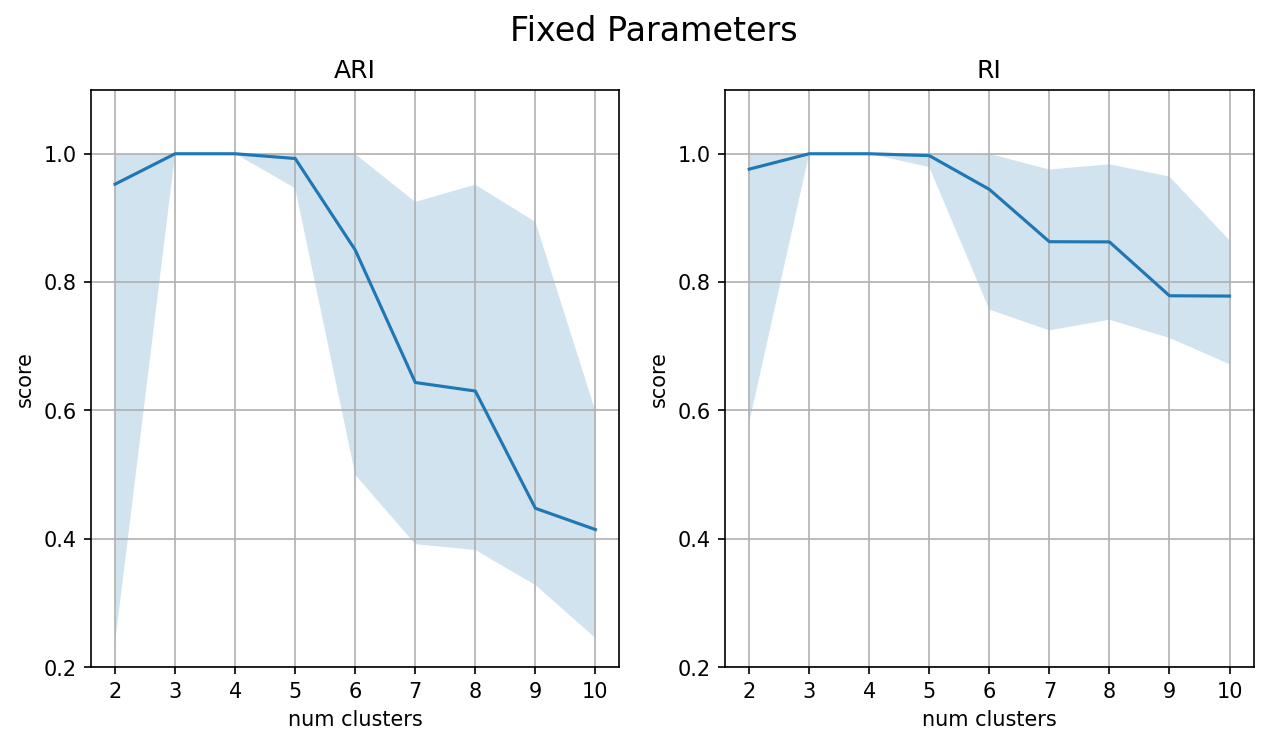

In [72]:
# Fixed parameters
plot_result(clusters_min,  clusters_max, fixed_mean_ari, fixed_min_ari, fixed_max_ari, fixed_mean_ar, fixed_min_ar, fixed_max_ar, "Fixed Parameters")

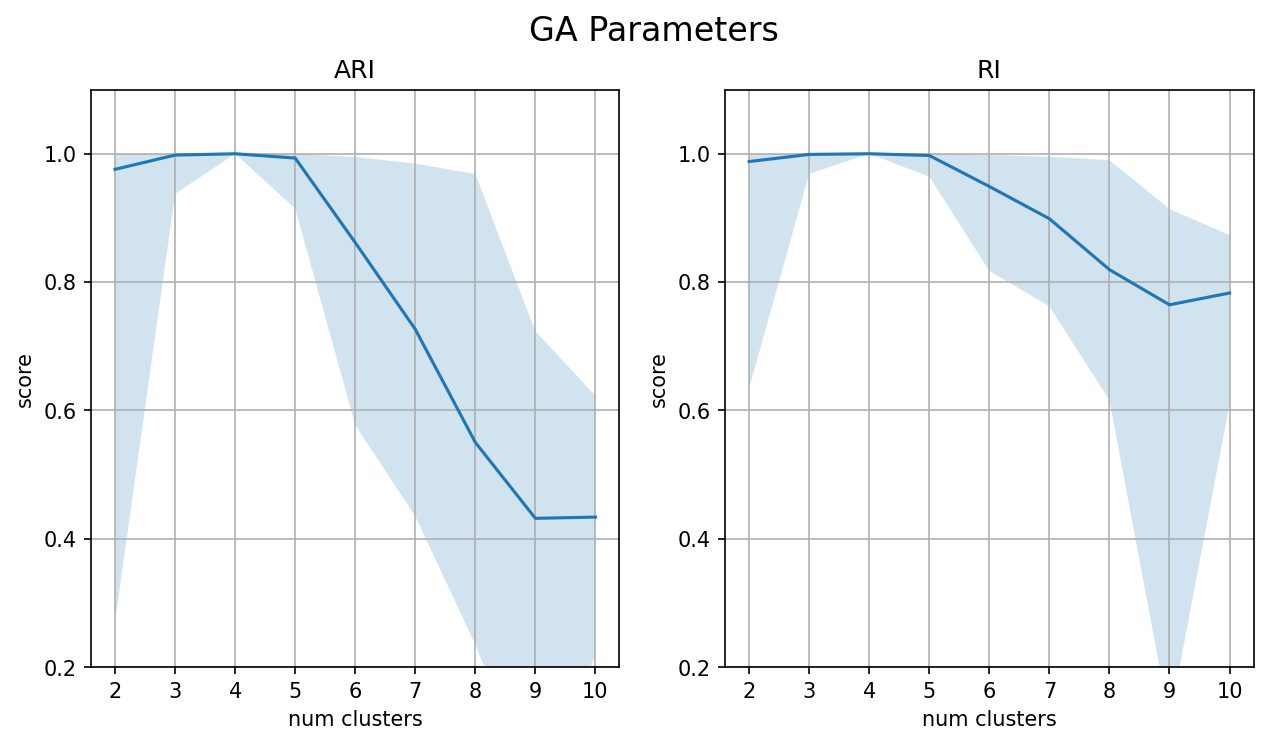

In [73]:
# Fixed parameters
plot_result(clusters_min,  clusters_max, ga_mean_ari, ga_min_ari, ga_max_ari, ga_mean_ar, ga_min_ar, ga_max_ar, "GA Parameters")

In [70]:
import pandas as pd
def best_method(method1, method2, result1, result2):
    result = []
    for i in range(len(result2)):
        if result1[i] > result2[i]:
            result.append(method1)
        elif result1[i] < result2[i]:
            result.append(method2)
        else:
            result.append("Equal") 
    return result

df = pd.DataFrame()
df["Num clusters"] = [i for i in range(2,11)]
df["Fixed ari"] = fixed_mean_ari
df["Fixed ar"] = fixed_mean_ar
df["GA ari"] = ga_mean_ari
df["GA ar"] = ga_mean_ar
df["Best ari"] = best_method("GA", "Fixed", ga_mean_ari, fixed_mean_ari)
df["Best ar"] = best_method("GA", "Fixed", ga_mean_ar, fixed_mean_ar)
df

,Num clusters,Fixed ari,Fixed ar,GA ari,GA ar,Best ari,Best ar
0,2,0.952589,0.975984,0.975695,0.987834,GA,GA
1,3,1.000000,1.000000,0.997913,0.998956,Fixed,Fixed
2,4,1.000000,1.000000,1.000000,1.000000,Equal,Equal
3,5,0.992561,0.997084,0.993272,0.997286,GA,GA
4,6,0.849935,0.944469,0.861555,0.948985,GA,GA
5,7,0.643491,0.862913,0.726394,0.898753,GA,GA
6,8,0.630180,0.862628,0.550109,0.819406,Fixed,Fixed
7,9,0.447469,0.778694,0.431815,0.764610,Fixed,Fixed
8,10,0.414322,0.778201,0.433749,0.782941,GA,GA
